Successfully loaded ai_job_market.csv

Dropped 0 rows with missing data.

Task: Predict 'experience_level' using ['industry', 'employment_type', 'company_size']
Total samples: 2000
Classes: ['Entry' 'Mid' 'Senior']

Running 10-Fold Stratified Cross-Validation...

--- Cross-Validation Results ---
Fold  1: Accuracy = 0.3800
Fold  2: Accuracy = 0.3650
Fold  3: Accuracy = 0.3100
Fold  4: Accuracy = 0.3350
Fold  5: Accuracy = 0.3750
Fold  6: Accuracy = 0.3050
Fold  7: Accuracy = 0.3400
Fold  8: Accuracy = 0.3100
Fold  9: Accuracy = 0.3450
Fold 10: Accuracy = 0.3400
------------------------------
Mean Accuracy: 0.3405
Std Deviation: 0.0255
----------------------------------

Generating graphical representation of fold accuracies...


/tmp/ipython-input-3239017007.py:109: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=fold_numbers, y=scores, palette='viridis')


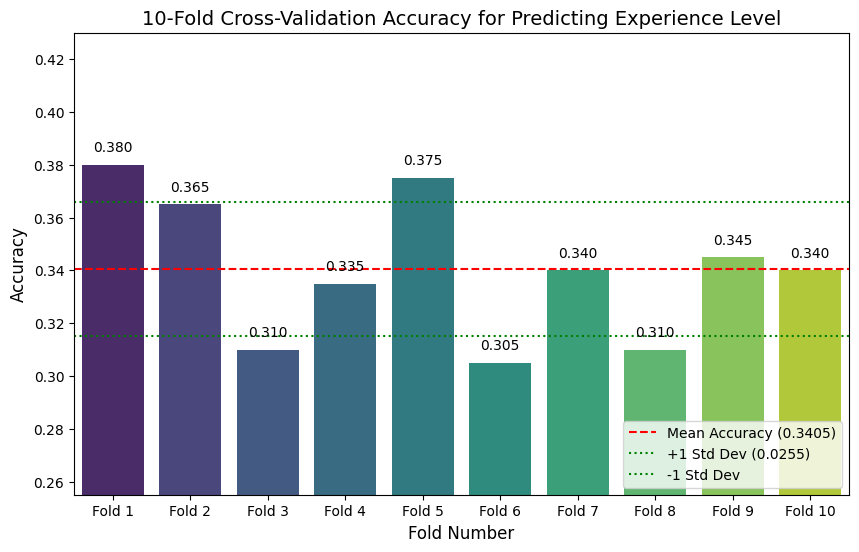

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, accuracy_score

def run_kfold_classification():
    """
    Loads the AI job market dataset and performs 10-fold cross-validation
    to predict 'experience_level'.
    """

    # --------------------------
    # 1. Load and Prepare Data
    # --------------------------
    try:
        df = pd.read_csv("ai_job_market.csv")
        print("Successfully loaded ai_job_market.csv\n")
    except FileNotFoundError:
        print("Error: ai_job_market.csv not found.")
        print("Please make sure the file is in the same directory as the script.")
        return

    # Define the classification task:
    # Predict 'experience_level' (y) using these features (X).
    features_list = ['industry', 'employment_type', 'company_size']
    target = 'experience_level'

    # Clean the data: drop rows where our target or features are missing
    original_count = len(df)
    df.dropna(subset=features_list + [target], inplace=True)
    print(f"Dropped {original_count - len(df)} rows with missing data.")

    X = df[features_list]
    y = df[target]

    print(f"\nTask: Predict '{target}' using {features_list}")
    print(f"Total samples: {len(y)}")
    print(f"Classes: {np.unique(y)}\n")

    # --------------------------
    # 2. Define Preprocessing and Model Pipeline
    # --------------------------

    # We must convert categorical text features (like 'Tech', 'Full-time')
    # into numerical data for the model. OneHotEncoder is best for this.

    # We will use a Pipeline to ensure that the OneHotEncoder is
    # correctly fit *only* on the training data for each fold.

    # Step 1: The preprocessor
    # handle_unknown='ignore' tells the encoder to ignore categories
    # in the test set that it didn't see in the training set.
    preprocessor = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

    # Step 2: The model (a simple classifier as requested)
    model = DecisionTreeClassifier(random_state=42)

    # Step 3: Create the pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    # --------------------------
    # 3. Set up and Run K-Fold Cross-Validation
    # --------------------------

    # We use StratifiedKFold to ensure that each fold has roughly the
    # same proportion of 'Entry', 'Mid', and 'Senior' level jobs.
    N_SPLITS = 10
    kfold = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

    print(f"Running {N_SPLITS}-Fold Stratified Cross-Validation...")

    # cross_val_score will automatically:
    # 1. Split the data into 10 folds (using our 'kfold' definition)
    # 2. For each fold:
    #    - Train the 'pipeline' on 9 folds
    #    - Test it on the 1 hold-out fold
    # 3. Return a list of the accuracy scores from all 10 runs.
    scores = cross_val_score(pipeline, X, y, cv=kfold, scoring='accuracy')

    # --------------------------
    # 4. Show Results
    # --------------------------
    print("\n--- Cross-Validation Results ---")
    for i, score in enumerate(scores):
        print(f"Fold {i+1:2}: Accuracy = {score:.4f}")

    print("-" * 30)
    print(f"Mean Accuracy: {np.mean(scores):.4f}")
    print(f"Std Deviation: {np.std(scores):.4f}")
    print("----------------------------------\n")

    # --------------------------
    # 5. Graphical Representation
    # --------------------------
    print("Generating graphical representation of fold accuracies...")

    plt.figure(figsize=(10, 6))
    fold_numbers = [f"Fold {i+1}" for i in range(N_SPLITS)]

    # Create bar plot
    ax = sns.barplot(x=fold_numbers, y=scores, palette='viridis')

    # Add mean and std deviation lines
    mean_acc = np.mean(scores)
    std_acc = np.std(scores)

    ax.axhline(mean_acc, color='r', linestyle='--', label=f'Mean Accuracy ({mean_acc:.4f})')
    ax.axhline(mean_acc + std_acc, color='g', linestyle=':', label=f'+1 Std Dev ({std_acc:.4f})')
    ax.axhline(mean_acc - std_acc, color='g', linestyle=':', label=f'-1 Std Dev')

    # Add text labels for each bar
    for i, score in enumerate(scores):
        ax.text(i, score + 0.005, f'{score:.3f}', ha='center', color='black')

    plt.title(f'{N_SPLITS}-Fold Cross-Validation Accuracy for Predicting Experience Level', fontsize=14)
    plt.xlabel('Fold Number', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.ylim(min(scores) - 0.05, max(scores) + 0.05) # Adjust y-axis to fit text
    plt.legend(loc='lower right')
    plt.show()

if __name__ == "__main__":
    run_kfold_classification()